In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

2024-09-03 13:42:53.321545: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-03 13:42:53.322891: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 13:42:53.326808: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 13:42:53.340246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 13:42:53.363070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [6]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = tf.cast(x_train, tf.float32), tf.cast(x_test, tf.float32)

num_classes = 10
num_features = x_train.shape[1] * x_train.shape[2] #(# of image, W, H)
# W * X
print(num_classes, num_features)

x_train, x_test = tf.reshape(x_train, [-1, num_features]), tf.reshape(x_test, [-1, num_features])
x_train, x_test = x_train/255., x_test/255. # 정규화를 위해 255로 나눴다.

10 784


In [8]:
from tensorflow.keras import Model, layers

class NeuralNet(Model):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = layers.Dense(128, activation = tf.nn.relu) #  128은 X * W -> 128 dim에 있다.
        self.fc2 = layers.Dense(256, activation = tf.nn.relu) # W: (128, 256) X * W -> 256 dim
        self.out = layers.Dense(num_classes) # 0 image -> (0.9, 0.01, ... , 0.02) (예측 확률)
    
    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x) # -> (1, 1, 0.8, ... , -1.2)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

In [9]:
neural_net = NeuralNet()

In [22]:
def cross_entropy_loss(x, y):
    y = tf.cast(y, tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = x)
    return tf.reduce_mean(loss)

def accuracy(y_pred, y_true): #  네트워크, 중요 함수 (0.9, 0.01, ... , 0.02) (예측 확률) ->
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64)) # y_pred in (N, 10) -> (N)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) # correct_prediction (N) (1,0, 0,1, 1,1, 1,1, ...)
    

In [25]:
lr = 0.003
optimizer = tf.optimizers.SGD(lr) # w_nex = w-learning_rate + gradient

# w-gradient(loss(prediction))

def run_optimization(x, y):
    with tf.GradientTape() as g: # 연산의 결과를 저장
        pred = neural_net(x, is_training=True)
        loss = cross_entropy_loss(pred, y)
    
    trainable_variables = neural_net.trainable_variables
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables)) # w_nex = w-learning_rate + gradient

In [26]:
batch_size = 200
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(60000).batch(batch_size).prefetch(1)

epoch = 40 # 60000 / 200 -> 300 -> 1epoch # 에폭 단위로 진행
display_epoch = 4

for epo in range(1, epoch+1):
    for step, (batch_x, batch_y) in enumerate(train_data, 1):
        run_optimization(batch_x, batch_y)
        
    if epo % display_epoch == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("epoch: ", epo, ", loss: ", loss.numpy(), ", acc: ", acc.numpy())

2024-09-03 14:43:14.156294: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-03 14:43:19.284534: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-03 14:43:30.612834: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


eㅔㅐch:  4 , loss:  1.8953834 , acc:  0.81


2024-09-03 14:43:53.200732: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


eㅔㅐch:  8 , loss:  1.7189438 , acc:  0.86
eㅔㅐch:  12 , loss:  1.6545068 , acc:  0.905


2024-09-03 14:44:36.398580: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


eㅔㅐch:  16 , loss:  1.6157643 , acc:  0.92
eㅔㅐch:  20 , loss:  1.6145669 , acc:  0.915
eㅔㅐch:  24 , loss:  1.6042922 , acc:  0.91
eㅔㅐch:  28 , loss:  1.6117595 , acc:  0.915


2024-09-03 14:46:02.815793: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


eㅔㅐch:  32 , loss:  1.6241771 , acc:  0.885
eㅔㅐch:  36 , loss:  1.5915347 , acc:  0.925
eㅔㅐch:  40 , loss:  1.5908976 , acc:  0.935


In [28]:
pred = neural_net(x_test)
print("Test Accuracy: ", accuracy(pred, y_test).numpy())

Test Accuracy:  0.9268


In [30]:
model2 = tf.keras.Sequential([tf.keras.layers.Dense(128, activation = 'relu'),
                             tf.keras.layers.Dense(256, activation = 'relu'),
                             tf.keras.layers.Dense(10)])

model2.compile(optimizer = 'SGD', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

inform = model2.fit(x_train, y_train, batch_size = 128, epochs = 40)

Epoch 1/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4822 - loss: 1.7695
Epoch 2/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8598 - loss: 0.5568
Epoch 3/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8898 - loss: 0.4022
Epoch 4/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9006 - loss: 0.3502
Epoch 5/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9077 - loss: 0.3212
Epoch 6/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9136 - loss: 0.3009
Epoch 7/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9181 - loss: 0.2848
Epoch 8/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9222 - loss: 0.2711
Epoch 9/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9260 - loss: 0.2590
Epoch 10/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9296 - loss: 0.2480
Epoch 11/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9322 - loss: 0.2379
Epoch 12/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

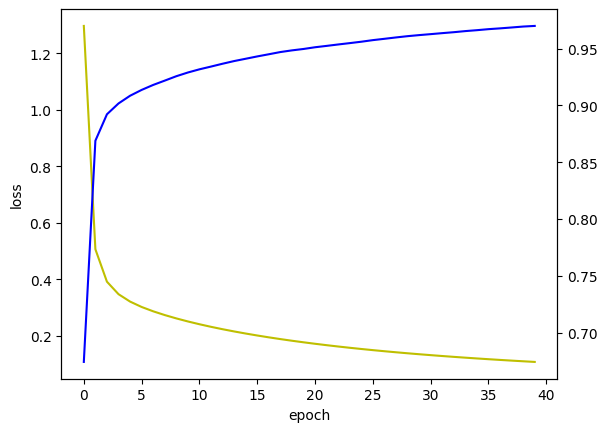

In [31]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(inform.history['loss'], 'y', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.plot(inform.history['accuracy'], 'b', label = 'train acc')

plt.show()